Yêu cầu này có thể sử dụng 2 dataset từ 2 bảng FactInternetSales, các bảng DimProduct (để train/test), bảng DimCustomer để lấy thông tin những khách đã mua hàng (train/test) và lấy thông tin những khách chưa mua hàng (để predict)

# Chuẩn bị dữ liệu

In [1]:
import pyodbc
import pandas as pd
import numpy as np

In [2]:
server_name = 'DESKTOP-TOL1F2F\MSSQLSERVERBI'
database_name = 'AdventureWorksDW2012'

connection = pyodbc.connect('Driver={SQL Server}; Server=' + server_name +
                      '; Database=' + database_name +
                      '; Trusted_Connection=yes;')

In [24]:
df = pd.read_sql_query(
    "select c.Gender as gender, \
        c.YearlyIncome as yearly_income, \
        c.MaritalStatus as marital_status, \
        c.TotalChildren as total_children, \
        c.NumberChildrenAtHome as children_at_home, \
        c.HouseOwnerFlag as house_owner, \
        c.NumberCarsOwned as cars_owned, \
        c.EnglishOccupation as occupation, \
        c.EnglishEducation as education,\
        c.CommuteDistance as commute_distance \
        , case sum(case pc.EnglishProductCategoryName when 'Bikes' then 1 else 0 end) \
          when 0 then 0 else 1 end as bikes \
        , case sum(case pc.EnglishProductCategoryName when 'Accessories' then 1 else 0 end) \
          when 0 then 0 else 1 end as accessories \
        , case sum(case pc.EnglishProductCategoryName when 'Clothing' then 1 else 0 end) \
          when 0 then 0 else 1 end as clothing \
        , case sum(case pc.EnglishProductCategoryName when 'Components' then 1 else 0 end) \
          when 0 then 0 else 1 end as components \
    from FactInternetSales f \
        join DimCustomer c on f.CustomerKey = c.CustomerKey \
        join DimProduct p on f.ProductKey = p.ProductKey \
        join DimProductSubcategory psc on p.ProductSubcategoryKey = psc.ProductSubcategoryKey \
        join DimProductCategory pc on psc.ProductCategoryKey = pc.ProductCategoryKey \
    group by c.Gender, c.YearlyIncome, c.MaritalStatus, c.TotalChildren, c.NumberChildrenAtHome, c.HouseOwnerFlag, \
        c.NumberCarsOwned, c.EnglishOccupation, c.EnglishEducation, c.CommuteDistance",
    connection) 

df.head()

,gender,yearly_income,marital_status,total_children,children_at_home,house_owner,cars_owned,occupation,education,commute_distance,bikes,accessories,clothing,components
0,M,90000.0,M,4,1,0,3,Management,High School,5-10 Miles,1,1,1,0
1,F,130000.0,M,1,3,1,3,Management,Bachelors,2-5 Miles,1,1,0,0
2,F,20000.0,M,2,1,1,2,Clerical,Partial High School,1-2 Miles,1,1,1,0
3,M,30000.0,M,1,0,1,1,Manual,High School,1-2 Miles,1,1,1,0
4,M,60000.0,M,3,2,0,2,Professional,Bachelors,0-1 Miles,1,1,0,0


# Thống kê mô tả
1. Thống kê kích thước tập dữ liệu
2. Thống kê các độ đo trung tâm, phân tán
3. Thống kê số lượng dữ liệu missing
4. Thống kê số loại dữ liệu của các biến định tính

## 1. Thống kê kích thước tập dữ liệu
- Tập dữ liệu được chọn có kích thước 14 cột và 3541 dòng
- Có 4 thuộc tính loại số là yearly_income, total_children, children_at_home và cars_owned
- Các thuộc tính phụ thuộc trong tập là bikes, accessories, clothing, component, có dạng số nhưng là binary (thuộc categorical)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4693 entries, 0 to 4692
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            4693 non-null   object 
 1   yearly_income     4693 non-null   float64
 2   marital_status    4693 non-null   object 
 3   total_children    4693 non-null   int64  
 4   children_at_home  4693 non-null   int64  
 5   house_owner       4693 non-null   object 
 6   cars_owned        4693 non-null   int64  
 7   occupation        4693 non-null   object 
 8   education         4693 non-null   object 
 9   commute_distance  4693 non-null   object 
 10  bikes             4693 non-null   int64  
 11  accessories       4693 non-null   int64  
 12  clothing          4693 non-null   int64  
 13  components        4693 non-null   int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 513.4+ KB


## 2. Thống kê các độ đo trung tâm, phân tán
- Tham số include='all' của hàm describe giúp cho kết quả hiển thị thêm 3 chỉ số thống kê cho các thuộc tính định tính
    - unique: số loại giá trị của thuộc tính
    - top: loại giá trị có số lượng nhiều nhất
    - freq: số lượng nhiều nhất của một loại giá trị
    
- Thuộc tính gender có 2 loại giá trị, xuất hiện nhiều nhất là M với 1798 lần
- Thuộc tính marital_status có 2 loại giá trị, xuất hiện nhiều nhất là M với 1948 lần
- Thuộc tính occupation có 5 loại giá trị, số lượng nhiều nhất là 1248 của Professional
- Thuộc tính education có 5 loại giá trị, số lượng nhiều nhất là Bachelors với 1039 lần
- Thuộc tính commute_distance có 5 loại giá trị, xuất hiện nhiều nhất là 0-1 Miles với 1206 lần

In [26]:
df.describe(include='all')

,gender,yearly_income,marital_status,total_children,children_at_home,house_owner,cars_owned,occupation,education,commute_distance,bikes,accessories,clothing,components
count,4693,4693.000000,4693,4693.000000,4693.000000,4693,4693.000000,4693,4693,4693,4693.000000,4693.00000,4693.000000,4693.0
unique,2,NaN,2,NaN,NaN,2,NaN,5,5,5,NaN,NaN,NaN,NaN
top,M,NaN,M,NaN,NaN,1,NaN,Professional,Bachelors,0-1 Miles,NaN,NaN,NaN,NaN
freq,2381,NaN,2558,NaN,NaN,2913,NaN,1609,1402,1586,NaN,NaN,NaN,NaN
mean,NaN,71896.441509,NaN,2.366503,1.585340,NaN,1.821649,NaN,NaN,NaN,0.591519,0.93437,0.614958,0.0
std,NaN,39805.370671,NaN,1.641819,1.747796,NaN,1.269832,NaN,NaN,NaN,0.491605,0.24766,0.486657,0.0
min,NaN,10000.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,0.000000,0.00000,0.000000,0.0
25%,NaN,40000.000000,NaN,1.000000,0.000000,NaN,1.000000,NaN,NaN,NaN,0.000000,1.00000,0.000000,0.0
50%,NaN,70000.000000,NaN,2.000000,1.000000,NaN,2.000000,NaN,NaN,NaN,1.000000,1.00000,1.000000,0.0
75%,NaN,100000.000000,NaN,4.000000,3.000000,NaN,3.000000,NaN,NaN,NaN,1.000000,1.00000,1.000000,0.0


## 3. Thống kê số lượng dữ liệu missing
- Tập dữ liệu đầy đủ

In [27]:
df.isna().sum()

gender              0
yearly_income       0
marital_status      0
total_children      0
children_at_home    0
house_owner         0
cars_owned          0
occupation          0
education           0
commute_distance    0
bikes               0
accessories         0
clothing            0
components          0
dtype: int64

## 4. Thống kê số loại dữ liệu của các biến định tính

In [28]:
for col in df.select_dtypes(include=[object]).columns:
    print(col)
    print(df[col].value_counts())
    print('='*30)

gender
M    2381
F    2312
Name: gender, dtype: int64
marital_status
M    2558
S    2135
Name: marital_status, dtype: int64
house_owner
1    2913
0    1780
Name: house_owner, dtype: int64
occupation
Professional      1609
Management        1256
Skilled Manual     847
Clerical           495
Manual             486
Name: occupation, dtype: int64
education
Bachelors              1402
Partial College        1209
High School             849
Graduate Degree         818
Partial High School     415
Name: education, dtype: int64
commute_distance
0-1 Miles     1586
2-5 Miles      837
1-2 Miles      763
5-10 Miles     761
10+ Miles      746
Name: commute_distance, dtype: int64


Nhận xét:
- 

# Mã hoá dữ liệu
Mã hoá các biến định tính
- Các biến dạng nominal: 
- Các biến dạng binary:

# Trực quan hoá dữ liệu

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

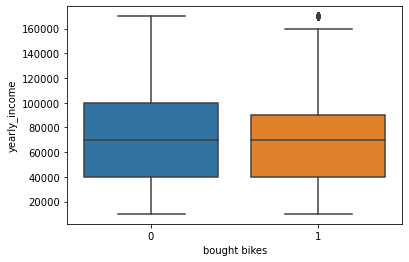

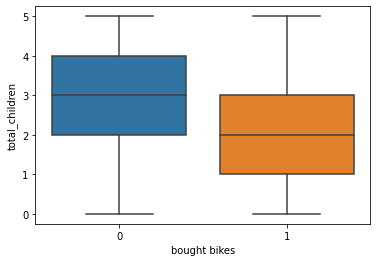

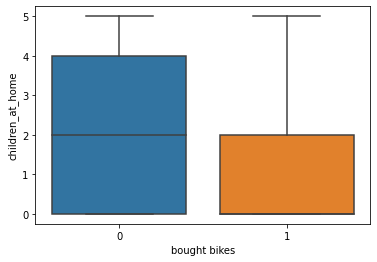

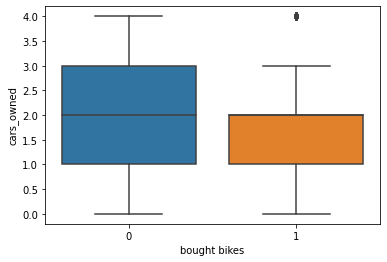

In [29]:
for col in df[['yearly_income', 'total_children', 'children_at_home', 'cars_owned']]:
    sns.boxplot('bikes', col, data=df)
    plt.xlabel('bought bikes')
    plt.ylabel(col)
    plt.show()

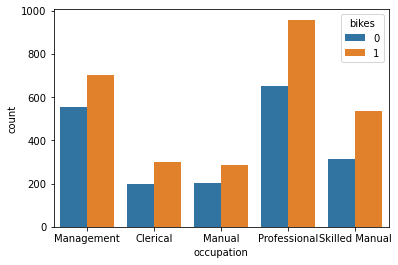

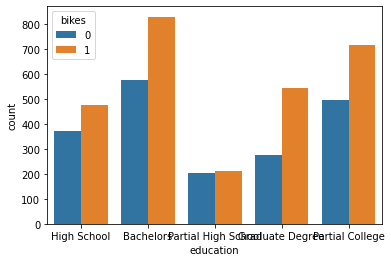

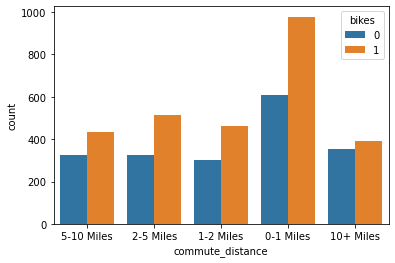

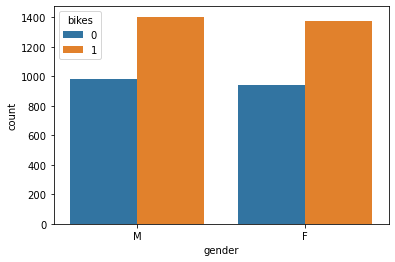

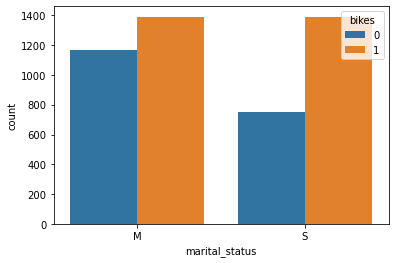

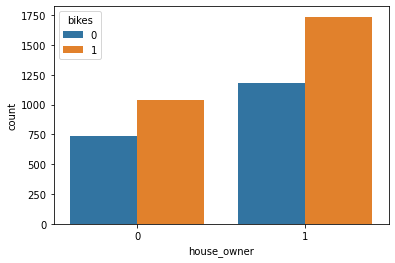

In [45]:
for col in ['occupation', 'education', 'commute_distance', 'gender', 'marital_status', 'house_owner']:
    ax = sns.countplot(x=col, hue='bikes', data=df)
    plt.show()